# Predicting Home Sale Price

This will attempt to be similar to the Zestimate used on Zillow, the Redfin estimate used on Redfin, or any of the valuations provided by Collateral Analytics, CoreLogic, or Quantarium on Realtor.com.

I will create a regression model and use it to predict valuation and compare to the other valuations on currently listed homes.

In [127]:
%run src/imports.py
from src.helpers import calculate_five_percent, calculate_ten_percent, calculate_twenty_percent

In [120]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+8-b765.1); OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from /Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/x9/yfstzcgs657dxpgy6xy50glm0000gn/T/tmpb23g78ei
  JVM stdout: /var/folders/x9/yfstzcgs657dxpgy6xy50glm0000gn/T/tmpb23g78ei/h2o_randallbloomquist_started_from_python.out
  JVM stderr: /var/folders/x9/yfstzcgs657dxpgy6xy50glm0000gn/T/tmpb23g78ei/h2o_randallbloomquist_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,"7 days, 1 hour and 53 minutes"
H2O_cluster_name:,H2O_from_python_randallbloomquist_jb6qzf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [43]:
sns.set(rc={'figure.figsize':(16,4)})

In [44]:
modeldata = pd.read_pickle('data/modeldata.pkl')

In [45]:
modeldata

,ZIP OR POSTAL CODE,PRICE,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS,MONTH,YEAR
0,78257,345000,1989.0,5662.0,2005.0,230.0,29.647801,-98.614186,4.0,9,2020
1,78256,337500,2166.0,9583.0,2004.0,54.0,29.650304,-98.629082,6.0,6,2020
2,78256,375500,2969.0,6605.0,2004.0,54.0,29.651842,-98.630650,6.5,3,2021
3,78255,462000,2716.0,9147.0,2014.0,95.0,29.617650,-98.643430,7.0,10,2018
4,78256,624000,3012.0,75794.0,2000.0,25.0,29.620646,-98.622295,5.5,2,2021
...,...,...,...,...,...,...,...,...,...,...,...
20007,78222,153000,1577.0,6969.0,1983.0,0.0,29.383410,-98.376520,5.0,9,2019
20008,78222,189900,1703.0,4791.0,2018.0,25.0,29.386700,-98.379900,6.0,7,2018
20009,78222,128000,1102.0,5662.0,1985.0,0.0,29.383092,-98.376562,5.0,3,2019
20010,78222,196499,2324.0,5662.0,2014.0,6.0,29.379346,-98.370269,7.0,3,2019


-----
Data Density  
= 19,812 / 11  
= 1801
-----
With smaller dataset  
= 1,000 / 11  
= 91
----

## Building a Model

Smaller set:

In [8]:
df_small = modeldata.sample(1000)
y = df_small['PRICE'].values
X = df_small.drop('PRICE',axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [25]:
y = modeldata['PRICE'].values
X = modeldata.drop('PRICE',axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [67]:
rfr = RandomForestRegressor(oob_score=True)
rfr.fit(X_train,y_train)
y_predict = rfr.predict(X_test)
print("score:", rfr.score(X_test, y_test))
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))
print(r2_score(y_test,y_predict))

score: 0.7995623956124502
MSE: 5.685604e+09
49.94952554007672
70.82576216434484
88.14859681001414
0.7995623956124502


In [10]:
search_space = [{'regressor__alpha': 10 ** (np.linspace(-5, 5, 10)), 
                 'regressor__l1_ratio': np.linspace(0,1,6)}]

# l_lasso / (l_lasso + l_ridge)
# if l_lasso = 0: 0 / 1 = 0 (this is ridge regression)
# if l_ridge = 0: l_lasso / l_lasso = 1 (this is LASSSO regression)

pipe = Pipeline([('scaler', StandardScaler()), ('regressor', ElasticNet())])

enet_cv = GridSearchCV(pipe, 
                      search_space, 
                      cv=KFold(10, shuffle=True), 
                      scoring='neg_mean_squared_error',
                      return_train_score = True)
enet_cv.fit(X_train,y_train)

print(enet_cv.best_params_)

y_predict = enet_cv.predict(X_test)
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2790398349155.116, tolerance: 1311002112.6500173
  model = cd_fast.enet_coordinate_descent(
/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3077268448852.238, tolerance: 1565508902.4464314
  model = cd_fast.enet_coordinate_descent(
/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2885331866344.253, tolerance: 1456204779.596652
  model = cd_fast.enet_coordinate_descent(
/Users/randallbloomquist/opt/anacon

{'regressor__alpha': 46.41588833612782, 'regressor__l1_ratio': 0.8}
MSE: 1.976368e+10
10.0
18.8
37.6


/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7527219272540.936, tolerance: 1505459135.7030735
  model = cd_fast.enet_coordinate_descent(


In [27]:
ridge = Ridge(alpha=1)
ridge.fit(X_train,y_train)
y_predict = ridge.predict(X_test)
print("score:", ridge.score(X_test, y_test))
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

score: 0.5362856621849305
MSE: 1.315370e+10
11.710074702200686
23.88451443569554
49.16212396527357


In [28]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_predict = lr.predict(X_test)
print("score:", lr.score(X_test, y_test))
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

score: 0.5362814077045177
MSE: 1.315382e+10
11.710074702200686
23.90470421966485
49.16212396527357


In [29]:
kf = KFold()
skf = StratifiedKFold()
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())])
ridge_grid_params = {'regressor__alpha': np.arange(0,50,1)}
ridge_grid = GridSearchCV(ridge_pipe, ridge_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_predict = ridge_grid.predict(X_test)
print("Ridge Accuracy: {:.2e}".format(ridge_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

Ridge Accuracy: -1.32e+10
11.710074702200686
23.90470421966485
49.16212396527357


In [30]:
kf = KFold()
skf = StratifiedKFold()
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso())])
lasso_grid_params = {'regressor__alpha': np.arange(0.1,0.9,0.1)}
lasso_grid = GridSearchCV(lasso_pipe, lasso_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
y_predict = lasso_grid.predict(X_test)
print("Lasso Accuracy: {:.2e}".format(lasso_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

Lasso Accuracy: -1.32e+10
11.710074702200686
23.90470421966485
49.16212396527357


In [31]:
kf = KFold()
skf = StratifiedKFold()
gbr_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', GradientBoostingRegressor(loss='huber'))])
gbr_grid_params = {'regressor__alpha': np.arange(0.1,0.9,0.2),
                  'regressor__max_depth': np.arange(1,9,2),
                  'regressor__learning_rate': np.arange(0.01,0.2,0.03)}
gbr_grid = GridSearchCV(gbr_pipe, gbr_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
gbr_grid.fit(X_train, y_train)
y_predict = gbr_grid.predict(X_test)
print("gbr Accuracy: {:.2e}".format(gbr_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

gbr Accuracy: -6.67e+09
46.17403593781547
69.3519079345851
86.71512214819302


In [35]:
gbr_grid.best_params_

{'regressor__alpha': 0.7000000000000001,
 'regressor__learning_rate': 0.13,
 'regressor__max_depth': 5}

In [32]:
kf = KFold()
skf = StratifiedKFold()
rfr_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor(warm_start=True))])
rfr_grid_params = {'regressor__n_estimators': np.arange(50,250,10),
                  'regressor__max_depth': np.arange(1,15,2)}
rfr_grid = GridSearchCV(rfr_pipe, rfr_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
rfr_grid.fit(X_train, y_train)
y_predict = rfr_grid.predict(X_test)
print("rfrAccuracy: {:.2e}".format(rfr_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

rfrAccuracy: -5.76e+09
42.13607914395316
67.47425802543913
86.93720977185544


In [56]:
kf = KFold()
skf = StratifiedKFold()
gbr_pipe2 = Pipeline([('scaler', StandardScaler()), ('regressor', GradientBoostingRegressor(loss='huber'))])
gbr_grid_params2 = {'regressor__alpha': np.arange(0.1,0.9,0.3)}
gbr_grid2 = GridSearchCV(gbr_pipe2, gbr_grid_params2, cv=kf, scoring = 'neg_mean_squared_error')
gbr_grid2.fit(X_train, y_train)
y_predict = gbr_grid2.predict(X_test)
print("gbr Accuracy: {:.2e}".format(gbr_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

gbr Accuracy: -6.87e+09
30.8
54.800000000000004
79.2


In [38]:
gbr_grid2.best_params_

{'regressor__alpha': 0.7000000000000001}

In [39]:
X_df = pd.DataFrame(X)

In [40]:
X_df.corr() > 0.2

,0,1,2,3,4,5,6,7,8,9
0,True,False,False,False,False,True,False,False,False,False
1,False,True,False,True,True,True,False,True,False,False
2,False,False,True,False,False,False,False,False,False,False
3,False,True,False,True,True,True,False,True,False,False
4,False,True,False,True,True,True,False,True,False,False
5,True,True,False,True,True,True,False,True,False,False
6,False,False,False,False,False,False,True,False,False,False
7,False,True,False,True,True,True,False,True,False,False
8,False,False,False,False,False,False,False,False,True,False
9,False,False,False,False,False,False,False,False,False,True


In [41]:
X_train = sm.add_constant(X_train)

In [42]:
X_opt = X_train[:,np.arange(0,10)]
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     104.8
Date:                Sat, 27 Mar 2021   Prob (F-statistic):          1.09e-125
Time:                        18:53:22   Log-Likelihood:                -9780.8
No. Observations:                 750   AIC:                         1.958e+04
Df Residuals:                     740   BIC:                         1.963e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.91e+07   7.25e+06      2.636      0.009    4.88e+06    3.33e+07
x1          -257.0925     97.375     -2.640      0.008    -448.258     -65.928
x2           167.3773      9.990     16.755      0.000     147.766     186.989
x3             0.4295      0.131      3.285      0.001       0.173       0.686
x4         -1767.9014    158.376    -11.163      0.000   -2078.821   -1456.982
x5           426.3365    173.307      2.460      0.014      86.104     766.569
x6            4.7e+04   5.06e+04      0.929      0.353   -5.23e+04    1.46e+05
x7         -3.107e+04   3.28e+04     -0.949      0.343   -9.54e+04    3.32e+04
x8         -1965.1738   5510.107     -0.357      0.721   -1.28e+04    8852.131
x9          -721.3523   1249.411     -0.577      0.564   -3174.166    1731.461
==============================================================================
Omnibus:                      771.327   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75725.392
Skew:                           4.492   Prob(JB):                         0.00
Kurtosis:                      51.399   Cond. No.                     1.39e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
X_opt = X_train[:,[0,1,2,4,5,6,7,8,9,10]]

In [44]:
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     102.9
Date:                Sat, 27 Mar 2021   Prob (F-statistic):          4.08e-124
Time:                        18:53:22   Log-Likelihood:                -9784.5
No. Observations:                 750   AIC:                         1.959e+04
Df Residuals:                     740   BIC:                         1.964e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.449e+06   1.22e+07      0.363      0.716   -1.96e+07    2.85e+07
x1          -264.8363     97.830     -2.707      0.007    -456.894     -72.778
x2           170.8658      9.960     17.156      0.000     151.313     190.418
x3         -1751.2316    159.717    -10.965      0.000   -2064.784   -1437.680
x4           466.5946    174.440      2.675      0.008     124.138     809.051
x5          5813.4052   4.99e+04      0.116      0.907   -9.22e+04    1.04e+05
x6         -1.517e+04   3.26e+04     -0.466      0.642   -7.92e+04    4.88e+04
x7         -1961.3432   5541.075     -0.354      0.723   -1.28e+04    8916.757
x8           -12.4337   1313.039     -0.009      0.992   -2590.160    2565.292
x9          8911.6173   4811.572      1.852      0.064    -534.339    1.84e+04
==============================================================================
Omnibus:                      760.353   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72443.149
Skew:                           4.391   Prob(JB):                         0.00
Kurtosis:                      50.340   Cond. No.                     2.33e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
sns_plot = sns.histplot(data=df['MONTH'],kde=True,shrink=2,binrange=[1,13],binwidth=.5).set_title('Houses Sold By Month')
fig = sns_plot.get_figure()
fig.savefig('img/housesbymonth.png')y_predict = regressor_OLS.predict(X_test)

In [46]:
print('MSE: {:.2e}'.format(mean_squared_error(y_test, y_predict)))

MSE: 1.21e+23


In [47]:
calculate_five_percent(y_predict,y_test)
calculate_ten_percent(y_predict,y_test)
print(calculate_twenty_percent(y_predict,y_test))

0.0


## Feature Importances

In [33]:
rfr_grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=13, n_estimators=120))])

In [34]:
rfr_grid.best_estimator_.steps[1][1]

RandomForestRegressor(max_depth=13, n_estimators=120)

In [35]:
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.steps[1][1].estimators_],axis=0)
std

array([0.01228483, 0.01883107, 0.00835079, 0.01407618, 0.02981249,
       0.01205757, 0.01754874, 0.00599366, 0.0031491 , 0.00503621])

In [36]:
feature_importances = rfr_grid.best_estimator_.steps[1][1].feature_importances_

In [37]:
feature_importances

array([0.04309778, 0.59934286, 0.05608799, 0.07904959, 0.07795421,
       0.06254325, 0.05392468, 0.01256994, 0.00746612, 0.00796357])

In [75]:
features = np.array(modeldata.drop('PRICE',axis=1).columns)

In [39]:
importances_df = pd.DataFrame([feature_importances],columns=features)
importances_df

,ZIP OR POSTAL CODE,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS,MONTH,YEAR
0,0.043098,0.599343,0.056088,0.07905,0.077954,0.062543,0.053925,0.01257,0.007466,0.007964


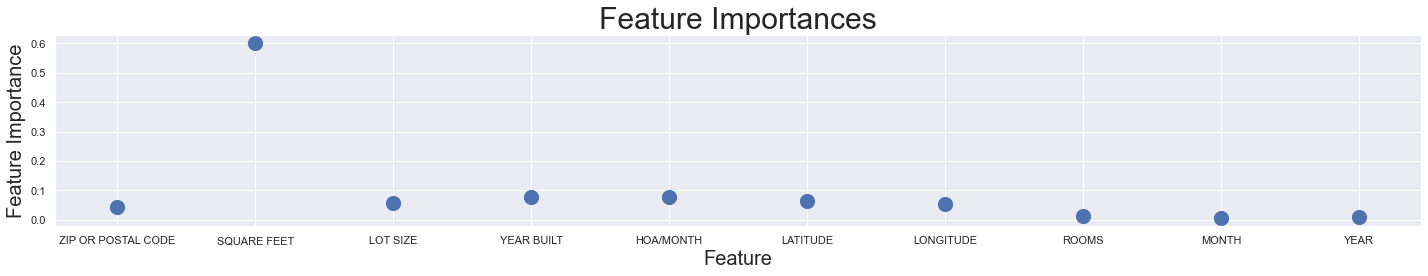

In [153]:
plt.figure(figsize=(20,4))
plt.scatter(x=features,y=feature_importances,s=200)
plt.title('Feature Importances',fontsize=30)
plt.ylabel('Feature Importance',fontsize=20)
plt.xlabel("Feature",fontsize=20)
plt.tight_layout()
plt.savefig('img/featureimportances2.png')

___

## Permutation Importance

In [46]:
r = permutation_importance(rfr_grid, X_test, y_test, n_repeats=30)

In [51]:
perm_importances = r.importances_mean

In [52]:
perm_importances_df = pd.DataFrame([perm_importances],columns=features)
perm_importances_df

,ZIP OR POSTAL CODE,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS,MONTH,YEAR
0,1.929978e+09,2.483626e+10,1.731492e+09,2.452394e+09,2.839793e+09,2.609847e+09,2.745420e+09,8.558712e+08,8.185933e+07,6.101866e+07


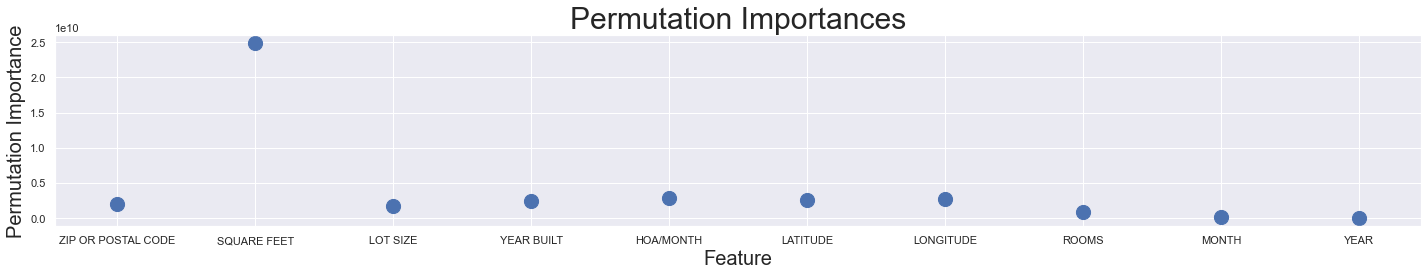

In [152]:
plt.figure(figsize=(20,4))
plt.scatter(x=features,y=perm_importances,s=200)
plt.title('Permutation Importances',fontsize=30)
plt.ylabel('Permutation Importance',fontsize=20)
plt.xlabel("Feature",fontsize=20)
plt.tight_layout()
plt.savefig('img/permimportances.png')


----

## Taking out square feet

In [58]:
X_nosf = modeldata.drop(['SQUARE FEET','PRICE'],axis=1).values

In [60]:
X_nosf.shape

(19812, 9)

In [61]:
y.shape

(19812,)

In [130]:
X_tr, X_te, y_tr, y_te = train_test_split(X_nosf,y)

In [63]:
df_small = modeldata.sample(1000)
y2 = df_small['PRICE'].values
X2 = df_small.drop(['SQUARE FEET','PRICE'],axis=1).values
X_tr, X_te, y_tr, y_te = train_test_split(X2,y2)

In [139]:
kf = KFold()
skf = StratifiedKFold()
rfr_pipe2 = Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor(warm_start=True))])
rfr_grid_params2 = {'regressor__n_estimators': np.arange(50,250,50),
                  'regressor__max_depth': np.arange(1,15,5)}
rfr_grid2 = GridSearchCV(rfr_pipe2, rfr_grid_params2, cv=kf, scoring = 'neg_mean_squared_error')
rfr_grid2.fit(X_tr, y_tr)


ValueError: X has 10 features, but this StandardScaler is expecting 9 features as input.

In [140]:
y_predict = rfr_grid2.predict(X_te)
print("rfrAccuracy: {:.2e}".format(rfr_grid.score(X_te, y_te)))
print(calculate_five_percent(y_predict,y_te))
print(calculate_ten_percent(y_predict,y_te))
print(calculate_twenty_percent(y_predict,y_te))
print(r2_score(y_te,y_pre))

rfrAccuracy: -3.48e+12
32.68726024631536
57.37936604078337
82.09166161922067
0.8436287459267812


In [141]:
std = np.std([tree.feature_importances_ for tree in rfr_grid2.best_estimator_.steps[1][1].estimators_],axis=0)
FI2 = rfr_grid2.best_estimator_.steps[1][1].feature_importances_

In [132]:
#FI2 = rfr2.feature_importances_

In [142]:
features2 = np.array(modeldata.drop(['PRICE','SQUARE FEET'],axis=1).columns)

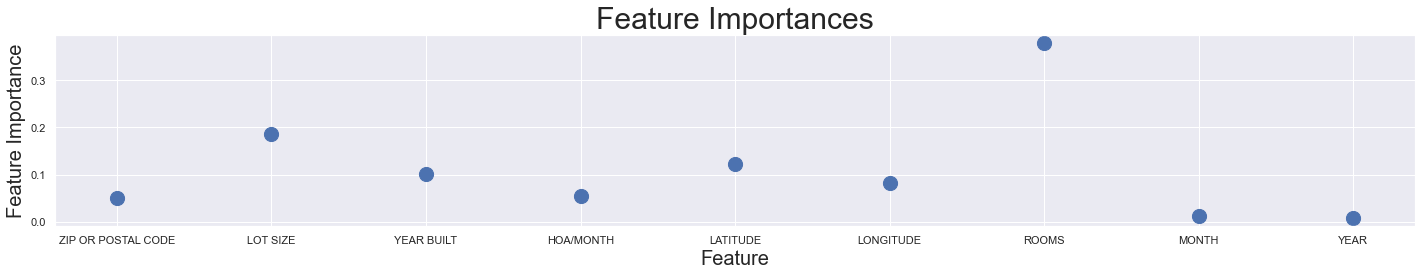

In [151]:
plt.figure(figsize=(20,4))
plt.scatter(x=features2,y=FI2,s=200)
plt.title('Feature Importances',fontsize=30)
plt.ylabel('Feature Importance',fontsize=20)
plt.xlabel("Feature",fontsize=20)
plt.tight_layout()
plt.savefig('img/FI2.png')

## Permutation Importance

In [144]:
r = permutation_importance(rfr_grid2, X_te, y_te, n_repeats=30)

In [145]:
perm_importances2 = r.importances_mean

In [146]:
perm_importances_df2 = pd.DataFrame([perm_importances2],columns=features2)
perm_importances_df2

,ZIP OR POSTAL CODE,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS,MONTH,YEAR
0,3.697318e+09,6.146930e+09,3.009588e+09,1.680061e+09,5.595946e+09,4.038186e+09,7.789140e+09,1.645248e+07,4.013530e+07


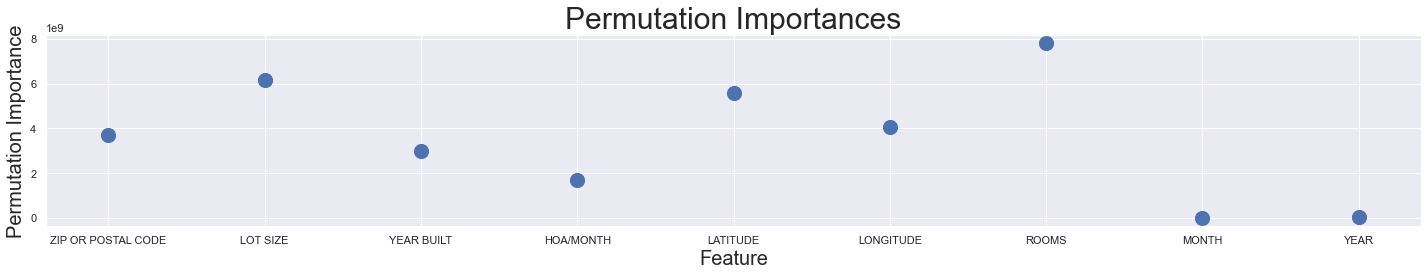

In [148]:
plt.figure(figsize=(20,4))
plt.scatter(x=features2,y=perm_importances2,s=200)
plt.title('Permutation Importances',fontsize=30)
plt.ylabel('Permutation Importance',fontsize=20)
plt.xlabel("Feature",fontsize=20)
plt.tight_layout()
plt.savefig('img/permimportances2.png')


-----

## Taking Out Rooms

In [78]:
X_norooms = modeldata.drop(['ROOMS','PRICE'],axis=1).values

In [79]:
X_norooms.shape

(19812, 9)

In [80]:
y.shape

(19812,)

In [81]:
X_tr, X_te, y_tr, y_te = train_test_split(X_norooms,y)

In [94]:
df_small = modeldata.sample(1000)
y3 = df_small['PRICE'].values
X3 = df_small.drop(['ROOMS','PRICE'],axis=1).values
X_tr, X_te, y_tr, y_te = train_test_split(X_norooms,y)

In [95]:
rfr3 = RandomForestRegressor(oob_score=True)
rfr3.fit(X_tr,y_tr)
y_pre = rfr3.predict(X_te)
print("score:", rfr.score(X_te, y_te))
print('MSE: {:2e}'.format(mean_squared_error(y_te, y_pre)))
print(calculate_five_percent(y_pre,y_te))
print(calculate_ten_percent(y_pre,y_te))
print(calculate_twenty_percent(y_pre,y_te))
print(r2_score(y_te,y_pre))

score: -0.2572512134129459
MSE: 2.256825e+09
49.94952554007672
71.81506157884111
88.49182313749243
0.8979368516467979


In [96]:
FI3 = rfr3.feature_importances_

In [97]:
features3 = np.array(modeldata.drop(['PRICE','ROOMS'],axis=1).columns)

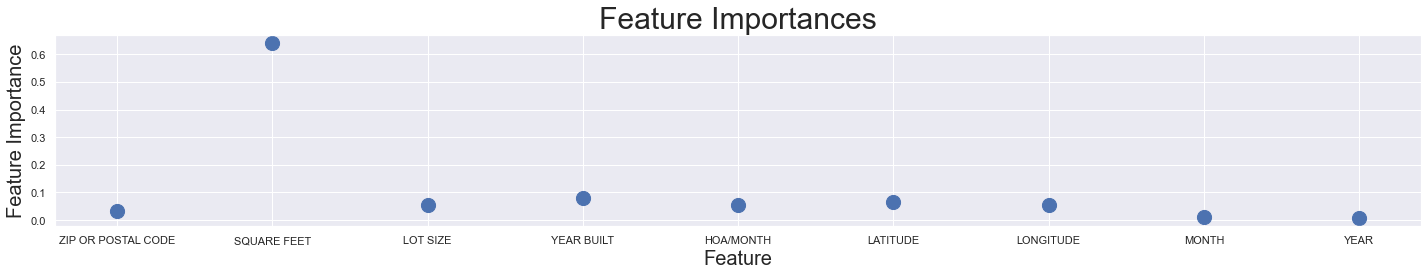

In [149]:
plt.figure(figsize=(20,4))
plt.scatter(x=features3,y=FI3,s=200)
plt.title('Feature Importances',fontsize=30)
plt.ylabel('Feature Importance',fontsize=20)
plt.xlabel("Feature",fontsize=20)
plt.tight_layout()
plt.savefig('img/FI3.png')

In [110]:
kf = KFold()
skf = StratifiedKFold()
rfr_pipe_rooms = Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor(oob_score=True))])
rfr__rooms_grid_params = {'regressor__n_estimators': np.arange(50,250,50),
                  'regressor__max_depth': np.arange(1,15,5)}
rfr_rooms_grid = GridSearchCV(rfr_pipe_rooms, rfr__rooms_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
rfr_rooms_grid.fit(X_tr, y_tr)
y_predict = rfr_rooms_grid.predict(X_te)
print("rfrAccuracy: {:.2e}".format(rfr_rooms_grid.score(X_te, y_te)))
print(calculate_five_percent(y_predict,y_te))
print(calculate_ten_percent(y_predict,y_te))
print(calculate_twenty_percent(y_predict,y_te))
print(r2_score(y_te,y_predict))

rfrAccuracy: -2.63e+09
38.50191802947708
63.355542095699576
85.2614577024026
0.8811134493806448


In [111]:
rfr_rooms_grid.best_params_

{'regressor__max_depth': 11, 'regressor__n_estimators': 50}

## Permutation Importance

In [112]:
r = permutation_importance(rfr_rooms_grid, X_te, y_te, n_repeats=30)

In [113]:
perm_importances3 = r.importances_mean

In [114]:
perm_importances_df3 = pd.DataFrame([perm_importances3],columns=features3)
perm_importances_df3

,ZIP OR POSTAL CODE,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,MONTH,YEAR
0,1.569812e+09,2.245047e+10,1.077457e+09,2.726916e+09,2.298973e+09,2.244883e+09,2.204259e+09,4.109035e+07,7.656289e+07


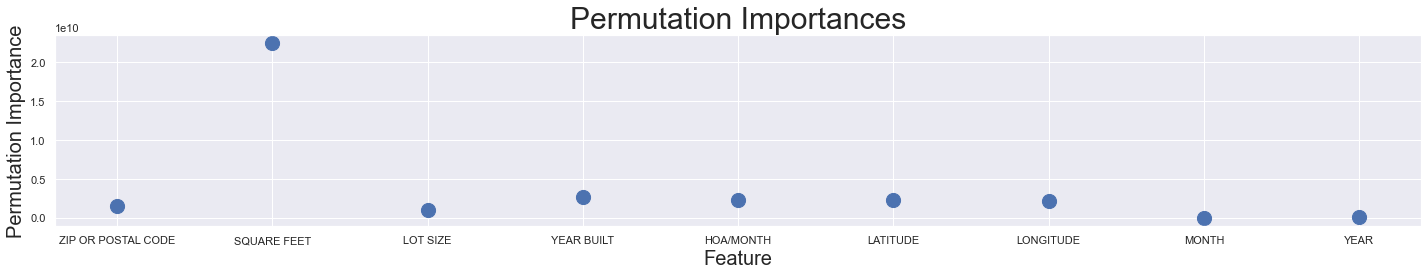

In [150]:
plt.figure(figsize=(20,4))
plt.scatter(x=features3,y=perm_importances3,s=200)
plt.title('Permutation Importances',fontsize=30)
plt.ylabel('Permutation Importance',fontsize=20)
plt.xlabel("Feature",fontsize=20)
plt.tight_layout()
plt.savefig('img/permimportances3.png')


-----

-----

# H2O Random Forest Model

In [122]:
neighborhoods_df = pd.read_pickle('data/neighborhoods.pkl')

In [123]:
neighborhoods_df.sample(2)

,ZIP OR POSTAL CODE,PRICE,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS,MONTH,YEAR
1908,78253,336899,Fronterra At Westpointe - Bexa,2377.0,9147.0,2020.0,40.0,29.455971,-98.726593,7.0,10,2020
7587,78154,294000,Rhine Valley,2843.0,5662.0,2018.0,31.0,29.531783,-98.239924,9.0,10,2018


In [129]:
# Import dataset into H2O:
neighborhoods = h2o.import_file('data/neighborhoods/neighborhoods.csv')

# Set the predictors and response;
# set the response as a factor:
neighborhoods["PRICE"] = neighborhoods["PRICE"].asfactor()
predictors = ["LOCATION","SQUARE FEET","LOT SIZE","YEAR BUILT","ROOMS","MONTH","YEAR"]
response = "PRICE"

# Split the dataset into a train and valid set:
train, test = neighborhoods.split_frame(ratios=[.8])

# Build and train the model:
neighborhoods_drf = H2ORandomForestEstimator(ntrees=10,
                                    max_depth=5,
                                    min_rows=10,
                                    calibrate_model=True,
                                    calibration_frame=test,
                                    binomial_double_trees=True)
neighborhoods_drf.train(x=predictors,
               y=response,
               training_frame=train,
               validation_frame=test)

# Eval performance:
perf = neighborhoods_drf.model_performance()

# Generate predictions on a validation set (if necessary):
pred = neighborhoods_drf.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


H2OResponseError: ModelBuilderErrorV3  (water.exceptions.H2OModelBuilderIllegalArgumentException):
    timestamp = 1617372196318
    error_url = '/3/ModelBuilders/drf'
    msg = 'Illegal argument(s) for DRF model: DRF_model_python_1617328725089_1.  Details: ERRR on field: _calibrate_model: Model calibration is only currently supported for binomial models.'
    dev_msg = 'Illegal argument(s) for DRF model: DRF_model_python_1617328725089_1.  Details: ERRR on field: _calibrate_model: Model calibration is only currently supported for binomial models.'
    http_status = 412
    values = {'messages': [{'_log_level': 5, '_field_name': '_keep_cross_validation_models', '_message': 'Only for cross-validation.'}, {'_log_level': 5, '_field_name': '_keep_cross_validation_predictions', '_message': 'Only for cross-validation.'}, {'_log_level': 5, '_field_name': '_keep_cross_validation_fold_assignment', '_message': 'Only for cross-validation.'}, {'_log_level': 5, '_field_name': '_fold_assignment', '_message': 'Only for cross-validation.'}, {'_log_level': 5, '_field_name': '_tweedie_power', '_message': 'Only for Tweedie Distribution.'}, {'_log_level': 5, '_field_name': '_tweedie_power', '_message': 'Tweedie power is only used for Tweedie distribution.'}, {'_log_level': 5, '_field_name': '_quantile_alpha', '_message': 'Quantile (alpha) is only used for Quantile regression.'}, {'_log_level': 5, '_field_name': '_max_after_balance_size', '_message': 'Balance classes is false, hide max_after_balance_size'}, {'_log_level': 5, '_field_name': '_max_after_balance_size', '_message': 'Only used with balanced classes'}, {'_log_level': 5, '_field_name': '_class_sampling_factors', '_message': 'Class sampling factors is only applicable if balancing classes.'}, {'_log_level': 1, '_field_name': '_calibrate_model', '_message': 'Model calibration is only currently supported for binomial models.'}], 'algo': 'DRF', 'parameters': {'_train': {'name': 'py_11_sid_b152', 'type': 'Key'}, '_valid': {'name': 'py_12_sid_b152', 'type': 'Key'}, '_nfolds': 0, '_keep_cross_validation_models': True, '_keep_cross_validation_predictions': False, '_keep_cross_validation_fold_assignment': False, '_parallelize_cross_validation': True, '_auto_rebalance': True, '_preprocessors': None, '_seed': -1, '_fold_assignment': 'AUTO', '_categorical_encoding': 'AUTO', '_max_categorical_levels': 10, '_distribution': 'multinomial', '_tweedie_power': 1.5, '_quantile_alpha': 0.5, '_huber_alpha': 0.9, '_ignored_columns': ['HOA/MONTH', 'C1', 'LONGITUDE', 'ZIP OR POSTAL CODE', 'LATITUDE'], '_ignore_const_cols': True, '_weights_column': None, '_offset_column': None, '_fold_column': None, '_check_constant_response': True, '_is_cv_model': False, '_cv_fold': -1, '_score_each_iteration': False, '_max_runtime_secs': 0.0, '_stopping_rounds': 0, '_stopping_metric': 'AUTO', '_stopping_tolerance': 0.001, '_response_column': 'PRICE', '_balance_classes': False, '_max_after_balance_size': 5.0, '_class_sampling_factors': None, '_max_confusion_matrix_size': 20, '_checkpoint': None, '_pretrained_autoencoder': None, '_custom_metric_func': None, '_custom_distribution_func': None, '_export_checkpoints_dir': None, '_gainslift_bins': -1, '_auc_type': 'AUTO', '_ntrees': 10, '_max_depth': 5, '_min_rows': 10.0, '_nbins': 20, '_nbins_cats': 1024, '_min_split_improvement': 1e-05, '_histogram_type': 'AUTO', '_r2_stopping': 1.7976931348623157e+308, '_nbins_top_level': 1024, '_build_tree_one_node': False, '_score_tree_interval': 0, '_initial_score_interval': 4000, '_score_interval': 4000, '_sample_rate': 0.632, '_sample_rate_per_class': None, '_calibrate_model': True, '_calibration_frame': {'name': 'py_12_sid_b152', 'type': 'Key'}, '_col_sample_rate_change_per_level': 1.0, '_col_sample_rate_per_tree': 1.0, '_parallel_main_model_building': False, '_binomial_double_trees': True, '_mtries': -1}, 'error_count': 2}
    exception_msg = 'Illegal argument(s) for DRF model: DRF_model_python_1617328725089_1.  Details: ERRR on field: _calibrate_model: Model calibration is only currently supported for binomial models.'
    stacktrace =
        water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: DRF_model_python_1617328725089_1.  Details: ERRR on field: _calibrate_model: Model calibration is only currently supported for binomial models.
        water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:19)
        hex.ModelBuilder.trainModelOnH2ONode(ModelBuilder.java:327)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:51)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:16)
        water.api.RequestServer.serve(RequestServer.java:470)
        water.api.RequestServer.doGeneric(RequestServer.java:301)
        water.api.RequestServer.doPost(RequestServer.java:227)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:707)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:790)
        org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:865)
        org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:535)
        org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:255)
        org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1317)
        org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:203)
        org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:473)
        org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:201)
        org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1219)
        org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:144)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:126)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)
        water.webserver.jetty9.Jetty9ServerAdapter$LoginHandler.handle(Jetty9ServerAdapter.java:130)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:126)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)
        org.eclipse.jetty.server.Server.handle(Server.java:531)
        org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:352)
        org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:260)
        org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:281)
        org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:102)
        org.eclipse.jetty.io.ChannelEndPoint$2.run(ChannelEndPoint.java:118)
        org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.runTask(EatWhatYouKill.java:333)
        org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:310)
        org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:168)
        org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:126)
        org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:366)
        org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:762)
        org.eclipse.jetty.util.thread.QueuedThreadPool$2.run(QueuedThreadPool.java:680)
        java.base/java.lang.Thread.run(Thread.java:834)
    parameters = {'__meta': {'schema_version': 3, 'schema_name': 'DRFParametersV3', 'schema_type': 'DRFParameters'}, 'model_id': None, 'training_frame': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_11_sid_b152', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_11_sid_b152'}, 'validation_frame': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_12_sid_b152', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_12_sid_b152'}, 'nfolds': 0, 'keep_cross_validation_models': True, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'parallelize_cross_validation': True, 'distribution': 'multinomial', 'tweedie_power': 1.5, 'quantile_alpha': 0.5, 'huber_alpha': 0.9, 'response_column': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'PRICE', 'is_member_of_frames': None}, 'weights_column': None, 'offset_column': None, 'fold_column': None, 'fold_assignment': 'AUTO', 'categorical_encoding': 'AUTO', 'max_categorical_levels': 10, 'ignored_columns': ['HOA/MONTH', 'C1', 'LONGITUDE', 'ZIP OR POSTAL CODE', 'LATITUDE'], 'ignore_const_cols': True, 'score_each_iteration': False, 'checkpoint': None, 'stopping_rounds': 0, 'max_runtime_secs': 0.0, 'stopping_metric': 'AUTO', 'stopping_tolerance': 0.001, 'gainslift_bins': -1, 'custom_metric_func': None, 'custom_distribution_func': None, 'export_checkpoints_dir': None, 'auc_type': 'AUTO', 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'ntrees': 10, 'max_depth': 5, 'min_rows': 10.0, 'nbins': 20, 'nbins_top_level': 1024, 'nbins_cats': 1024, 'r2_stopping': 1.7976931348623157e+308, 'seed': -1, 'build_tree_one_node': False, 'sample_rate_per_class': None, 'col_sample_rate_per_tree': 1.0, 'col_sample_rate_change_per_level': 1.0, 'score_tree_interval': 0, 'min_split_improvement': 1e-05, 'histogram_type': 'AUTO', 'calibrate_model': True, 'calibration_frame': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_12_sid_b152', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_12_sid_b152'}, 'check_constant_response': True, 'mtries': -1, 'binomial_double_trees': True, 'sample_rate': 0.632}
    messages = [{'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'keep_cross_validation_models', 'message': 'Only for cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'keep_cross_validation_predictions', 'message': 'Only for cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'keep_cross_validation_fold_assignment', 'message': 'Only for cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'fold_assignment', 'message': 'Only for cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'tweedie_power', 'message': 'Only for Tweedie Distribution.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'tweedie_power', 'message': 'Tweedie power is only used for Tweedie distribution.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'quantile_alpha', 'message': 'Quantile (alpha) is only used for Quantile regression.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_after_balance_size', 'message': 'Balance classes is false, hide max_after_balance_size'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_after_balance_size', 'message': 'Only used with balanced classes'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'class_sampling_factors', 'message': 'Class sampling factors is only applicable if balancing classes.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'calibrate_model', 'message': 'Model calibration is only currently supported for binomial models.'}]
    error_count = 2
